Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Loading Dataset

In [ ]:
# Load the datasets
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

Data Exploration

In [ ]:
train_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,48,admin.,divorced,university.degree,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-0.1,93.200,-42.0,4.021,5195.8,no
1,33,technician,divorced,high.school,no,no,no,cellular,nov,tue,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
2,75,retired,divorced,basic.4y,unknown,yes,no,cellular,oct,thu,...,1,999,0,nonexistent,-3.4,92.431,-26.9,0.754,5017.5,yes
3,35,technician,married,professional.course,no,yes,yes,cellular,may,wed,...,1,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1,no
4,42,admin.,divorced,university.degree,no,yes,no,cellular,aug,mon,...,5,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no


In [ ]:
test_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,27,services,single,university.degree,no,yes,no,cellular,apr,thu,297,1,999,0,nonexistent,-1.8,93.075,-47.1,1.410,5099.1
1,31,self-employed,divorced,basic.9y,no,yes,no,cellular,may,fri,12,10,999,1,failure,-1.8,92.893,-46.2,1.250,5099.1
2,34,unemployed,married,basic.9y,no,yes,no,cellular,may,thu,218,4,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1
3,49,admin.,divorced,high.school,no,no,no,telephone,may,thu,136,3,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
4,29,admin.,married,unknown,no,unknown,unknown,telephone,jun,fri,83,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1


In [ ]:
print('Train Shape (rows, columns):', train_data.shape)
print('Test Shape (rows, columns):', test_data.shape)

Train Shape (rows, columns): (39188, 21)
Test Shape (rows, columns): (2000, 20)


In [ ]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39188 entries, 0 to 39187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             39188 non-null  int64  
 1   job             39188 non-null  object 
 2   marital         39188 non-null  object 
 3   education       39188 non-null  object 
 4   default         39188 non-null  object 
 5   housing         39188 non-null  object 
 6   loan            39188 non-null  object 
 7   contact         39188 non-null  object 
 8   month           39188 non-null  object 
 9   day_of_week     39188 non-null  object 
 10  duration        39188 non-null  int64  
 11  campaign        39188 non-null  int64  
 12  pdays           39188 non-null  int64  
 13  previous        39188 non-null  int64  
 14  poutcome        39188 non-null  object 
 15  emp.var.rate    39188 non-null  float64
 16  cons.price.idx  39188 non-null  float64
 17  cons.conf.idx   39188 non-null 

##Data Preprocessing

In [ ]:
def preprocess_data(df, is_train=True):
    """Preprocess the data with label encoding for categorical variables"""
    data = df.copy()

    # Identify categorical columns
    categorical_columns = data.select_dtypes(include=['object']).columns
    if is_train:
        categorical_columns = categorical_columns.drop('y') if 'y' in categorical_columns else categorical_columns

    # Label Encoding for categorical columns
    le = LabelEncoder()
    for column in categorical_columns:
        data[column] = le.fit_transform(data[column].astype(str))

    # Convert target variable for training data
    if is_train and 'y' in data.columns:
        data['y'] = le.fit_transform(data['y'])

    return data

In [ ]:
# Preprocess both datasets
train_processed = preprocess_data(train_data, is_train=True)
test_processed = preprocess_data(test_data, is_train=False)


Preprocessing data...


###Splitting Data

In [ ]:
# Prepare Training Data
X = train_processed.drop('y', axis=1)
y = train_processed['y']

In [ ]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


#Applying ML Models

In [ ]:
# 4. Model Training and Evaluation
def train_and_evaluate_model(model, model_name, X_train, X_val, y_train, y_val):
    """Train and evaluate a single model"""
    print(f"\nTraining {model_name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    val_pred_prob = model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Validation Accuracy': accuracy_score(y_val, val_pred),
        'Validation Precision': precision_score(y_val, val_pred),
        'Validation Recall': recall_score(y_val, val_pred),
        'Validation ROC-AUC': roc_auc_score(y_val, val_pred_prob)
    }

    return model, metrics

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100)
}

In [ ]:
# Train and evaluate all models
results = {}
all_metrics = []

for name, model in models.items():
    trained_model, metrics = train_and_evaluate_model(
        model, name, X_train, X_val, y_train, y_val
    )
    results[name] = trained_model
    all_metrics.append(metrics)


Training Logistic Regression...

Training Random Forest...

Training XGBoost...


In [ ]:
# Convert metrics to DataFrame
metrics_df = pd.DataFrame(all_metrics)
print("\nModel Performance Metrics:")
print(metrics_df)


Model Performance Metrics:
                 Model  Train Accuracy  Validation Accuracy  \
0  Logistic Regression        0.909282             0.911457   
1        Random Forest        1.000000             0.913754   
2              XGBoost        0.963381             0.914647   

   Validation Precision  Validation Recall  Validation ROC-AUC  
0              0.662921           0.407834            0.924262  
1              0.637536           0.512673            0.943676  
2              0.630406           0.554147            0.947254  


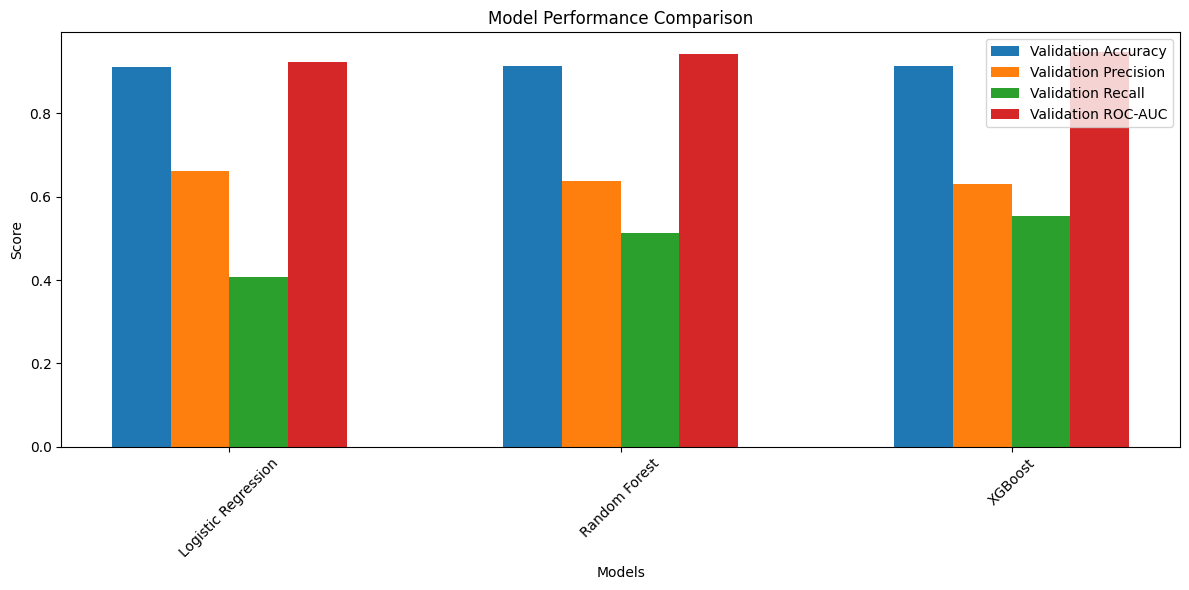

In [ ]:
# 5. Visualize Model Comparison
plt.figure(figsize=(12, 6))
metrics_to_plot = ['Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation ROC-AUC']

bar_width = 0.15
r = np.arange(len(models))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(r + i * bar_width, metrics_df[metric], bar_width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(r + bar_width * 1.5, metrics_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

###Predictions on Test Set

In [ ]:
print("\nGenerating predictions on test set...")
best_model_name = metrics_df.loc[metrics_df['Validation ROC-AUC'].idxmax(), 'Model']
best_model = results[best_model_name]

test_predictions = best_model.predict(test_processed)
test_probabilities = best_model.predict_proba(test_processed)[:, 1]


Generating predictions on test set...


In [ ]:
# Save predictions
predictions_df = pd.DataFrame({
    'Prediction': test_predictions,
    'Probability': test_probabilities
})
output_file = f'test_predictions_{best_model_name.lower().replace(" ", "_")}.csv'
predictions_df.to_csv(output_file, index=False)
print(f"Predictions saved to: {output_file}")

Predictions saved to: test_predictions_xgboost.csv


#SHAP Analysis

In [ ]:
# SHAP Analysis for Best Model
# Find best model based on ROC-AUC
best_model_name = metrics_df.loc[metrics_df['Validation ROC-AUC'].idxmax(), 'Model']
best_model = results[best_model_name]

print(f"\nPerforming SHAP analysis on best model: {best_model_name}")


Performing SHAP analysis on best model: XGBoost


In [ ]:
# Calculate SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val)

if isinstance(shap_values, list):  # For models that return a list of shap values
    shap_values = shap_values[1]

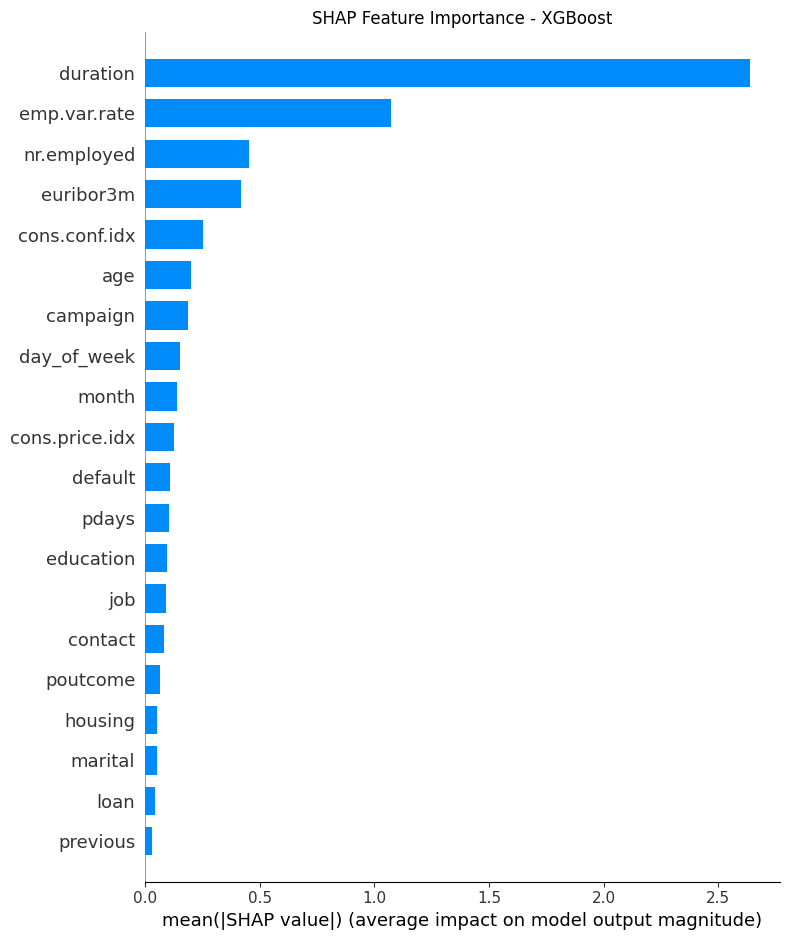

In [ ]:
# Plot SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val, plot_type="bar", show=False)
plt.title(f'SHAP Feature Importance - {best_model_name}')
plt.tight_layout()
plt.show()


Generating SHAP dependence plot for age...


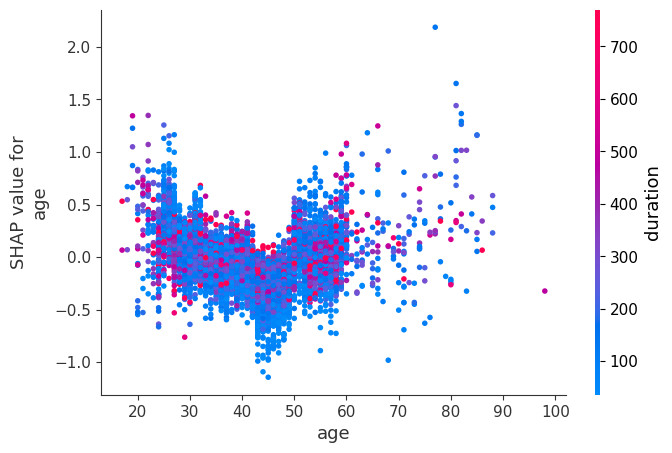

<Figure size 640x480 with 0 Axes>


Generating SHAP dependence plot for duration...


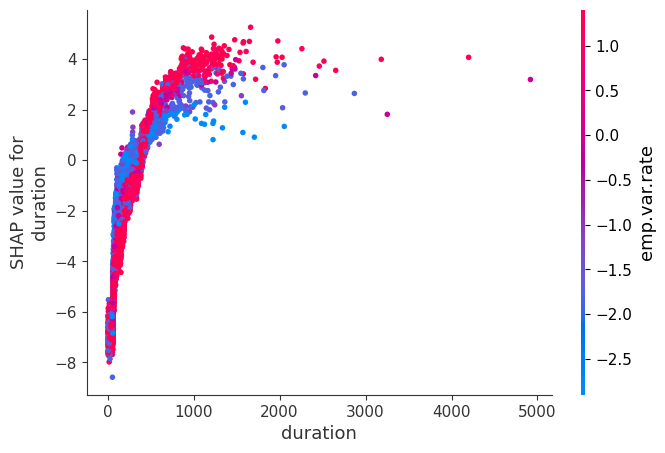

<Figure size 640x480 with 0 Axes>


Generating SHAP dependence plot for campaign...


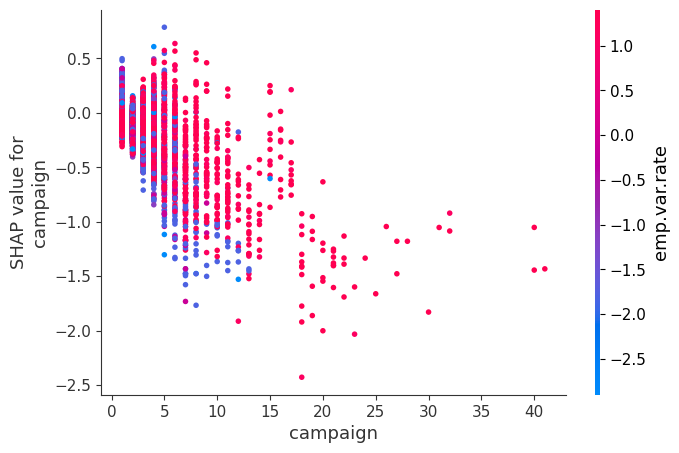

<Figure size 640x480 with 0 Axes>

In [ ]:
# 7. Further SHAP Analysis
# Generate SHAP dependence plot for key features
key_features = ['age', 'duration', 'campaign']  # Replace with key features of interest
for feature in key_features:
    print(f"\nGenerating SHAP dependence plot for {feature}...")
    shap.dependence_plot(feature, shap_values, X_val)
    plt.tight_layout()
    plt.show()


Generating SHAP force plots for sample records...



SHAP force plot for record 2500:


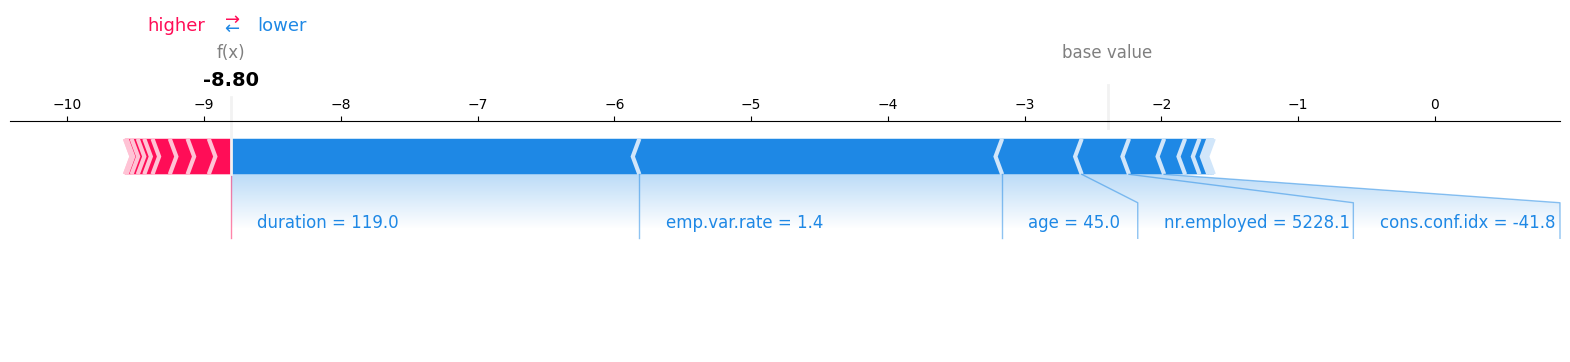


SHAP force plot for record 10:


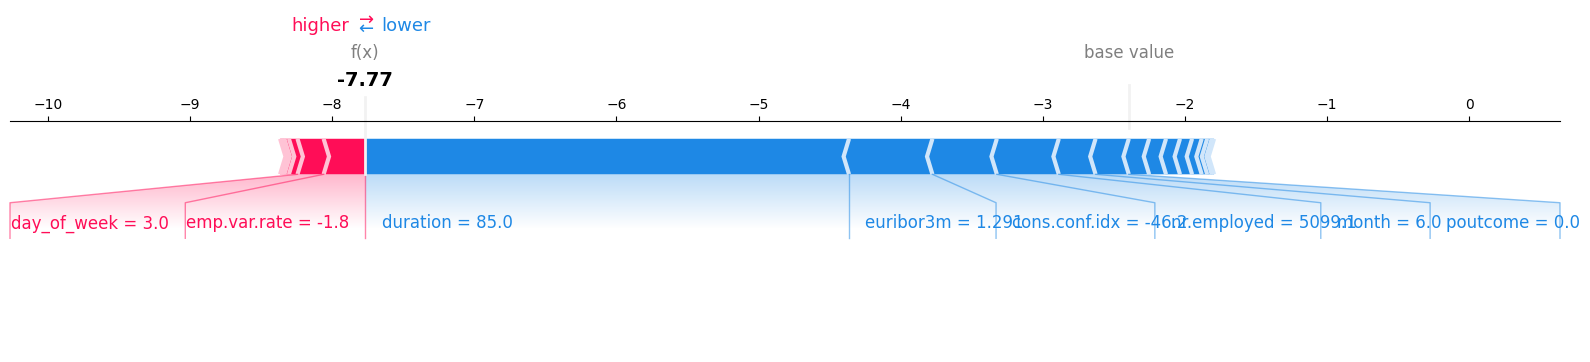


SHAP force plot for record 6000:


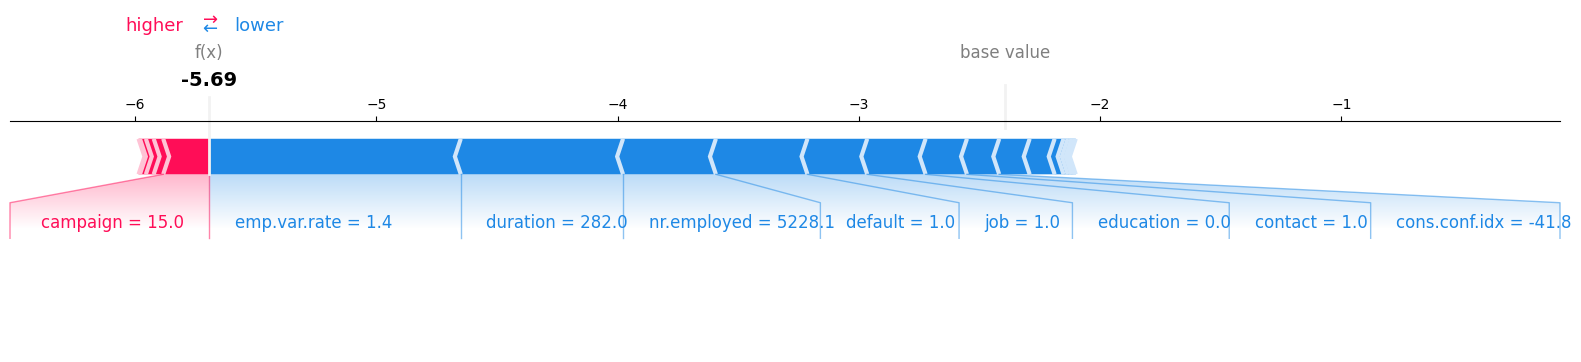

In [ ]:
# Generate SHAP force plots for a few sample records
print("\nGenerating SHAP force plots for sample records...")
shap.initjs()

sample_record_ids = [2500, 10, 6000]  # Adjust record IDs as needed
for record_id in sample_record_ids:
    print(f"\nSHAP force plot for record {record_id}:")
    shap.force_plot(explainer.expected_value, shap_values[record_id, :], X_val.iloc[record_id, :], matplotlib=True)
